In [620]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

import time
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import scipy as sc

from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.morphology import watershed
from scipy import ndimage as ndi
from math import sqrt
from skimage.feature import peak_local_max


# Check the images

In [483]:
images = glob.glob('vehicles/*/*.png')
cars = []
notcars = []
for image in images:
    cars.append(image)

images = glob.glob('non-vehicles/*/*.png')
for image in images:
    notcars.append(image)

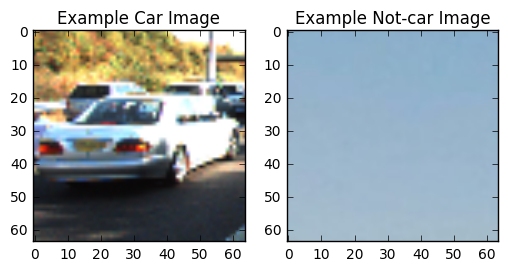

{'data_type': dtype('uint8'), 'image_shape': (64, 64, 3), 'n_cars': 8792, 'n_notcars': 9666}


In [485]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = sc.misc.imread(car_list[0]) #mpimg.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype

    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = sc.misc.imread(cars[car_ind]) #mpimg.imread(cars[car_ind])
notcar_image = sc.misc.imread(notcars[notcar_ind]) #mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

print(data_info)


# Get correct filters to use

In [486]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', cspacehog='HLS', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    convert =  isinstance(imgs[0], str)
#     min_val = 1000
#     max_val = 0
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        if convert:
            image = sc.misc.imread(img) #mpimg.imread(img)
        else:
            image = img
        
#         min_val = min(min_val, np.min(image))
#         max_val = max(max_val, np.max(image))
        
        # image = cv2.resize(image1, dsize = (142, 142))
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        if cspacehog != 'RGB':
            if cspacehog == 'HSV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspacehog == 'LUV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspacehog == 'HLS':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspacehog == 'YUV':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspacehog == 'YCrCb':
                feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image_hog = np.copy(image)      
            
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        # features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        # features.append(hog_features)
        features.append(np.concatenate((hog_features_0, hog_features_1, hog_features_2, hist_features)))
    #print('minmax:', min_val, max_val)
    # Return list of feature vectors
    return features

def extract_feature_1_img(img, cspace='RGB', cspacehog='HLS', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    convert =  isinstance(img, str)

    # Read in each one by one
    if convert:
        image = sc.misc.imread(img) #mpimg.imread(img)
    else:
        image = img

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if cspacehog != 'RGB':
        if cspacehog == 'HSV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspacehog == 'LUV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspacehog == 'HLS':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspacehog == 'YUV':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspacehog == 'YCrCb':
            feature_image_hog = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image_hog = np.copy(image)      

    # Apply bin_spatial() to get spatial color features
    #spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features_0, hog_image_0 = get_hog_features(feature_image_hog[:,:,0], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_features_1, hog_image_1 = get_hog_features(feature_image_hog[:,:,1], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    hog_features_2, hog_image_2 = get_hog_features(feature_image_hog[:,:,2], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    
    # Return list of feature vectors
    return hog_image_0, hog_image_1, hog_image_2, hist_features



In [487]:
_CSPACE_ = 'YCrCb'
_CSPACE_HOG_ = 'YCrCb'
_SPATIAL_SIZE_ = (8, 8)
_HIST_BINS_ = 32
_HIST_RANGE_ = (0, 256)
_ORIENT_ = 8
_PIX_PER_CELL_ = 8
_CELL_PER_BLOCK_ = 2
_HOG_CHANNEL_ = 1

In [502]:
car_features = extract_features(cars, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
notcar_features = extract_features(notcars, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
# notcar_features is a list
print(notcar_features[2].shape, notcar_features[0].shape, notcar_features[1].shape)
print(car_features[2].shape, car_features[0].shape, car_features[1].shape)


KeyboardInterrupt: 

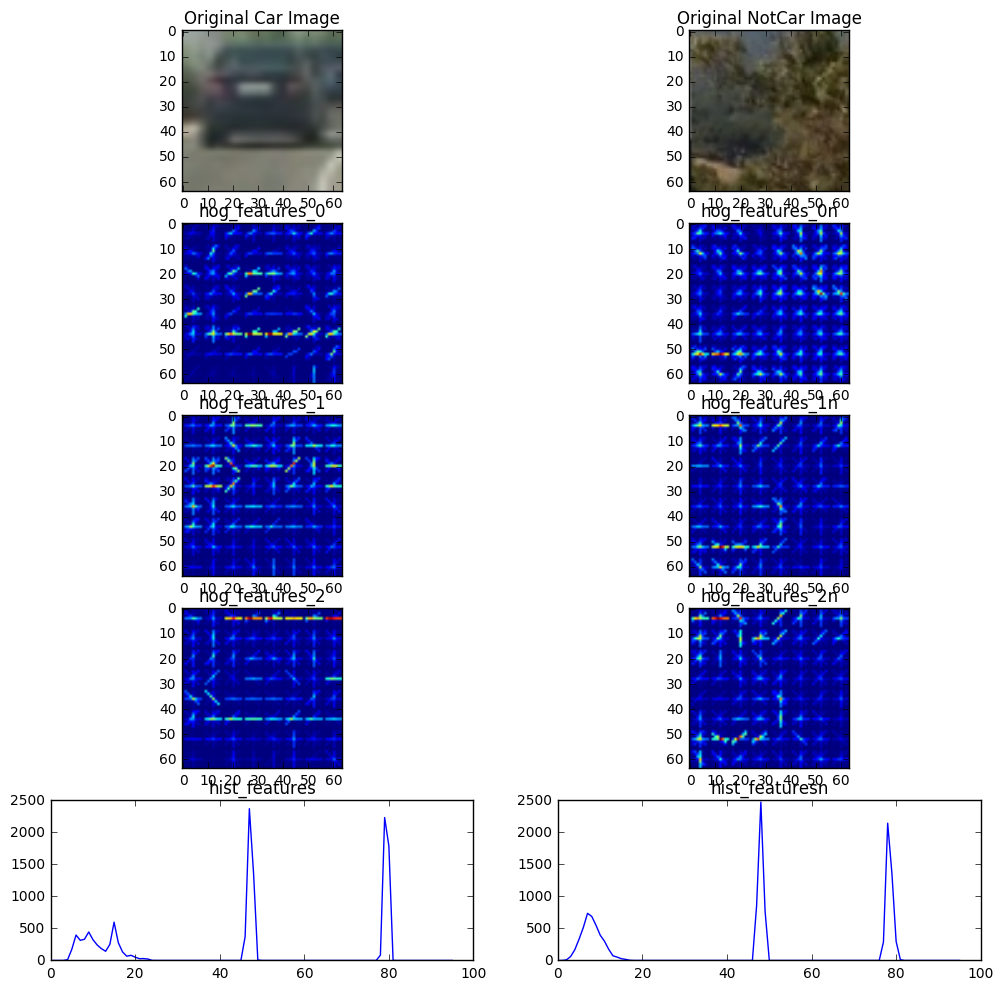

In [489]:
idx = 1

hog_image_0,  hog_image_1, hog_image_2, hist_features = extract_feature_1_img(cars[idx], cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
hog_image_0n,  hog_image_1n, hog_image_2n, hist_featuresn = extract_feature_1_img(notcars[idx], cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)

imgplot = sc.misc.imread(cars[idx])
imgplotn = sc.misc.imread(notcars[idx])

fig = plt.figure(figsize=(12,12))

plt.subplot(521)
plt.imshow(imgplot)
plt.title('Original Car Image')
plt.subplot(523)
plt.imshow(hog_image_0)
plt.title('hog_features_0')
plt.subplot(525)
plt.imshow(hog_image_1)
plt.title('hog_features_1')
plt.subplot(527)
plt.imshow(hog_image_2)
plt.title('hog_features_2')
plt.subplot(529)
plt.plot(hist_features)
plt.title('hist_features')

plt.subplot(522)
plt.imshow(imgplotn)
plt.title('Original NotCar Image')
plt.subplot(524)
plt.imshow(hog_image_0n)
plt.title('hog_features_0n')
plt.subplot(526)
plt.imshow(hog_image_1n)
plt.title('hog_features_1n')
plt.subplot(528)
plt.imshow(hog_image_2n)
plt.title('hog_features_2n')
plt.subplot(5,2,10)
plt.plot(hist_featuresn)
plt.title('hist_featuresn')

plt.show()

# Train SVM

In [491]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
print(X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

(18458, 4800)


In [492]:
# Use a linear SVC 
svc = LinearSVC(C=1.0) # TODO: CHECK WHY 
clf = CalibratedClassifierCV(svc) # to know the actual probability
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', clf.score(X_train, y_train))
print('Test Accuracy of SVC = ', clf.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = clf.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')


19.277220010757446 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.992145178765
0.0011589527130126953 Seconds to predict with SVC


In [515]:
import pickle
# save the model to disk
# filename = 'finalized_model.sav'
# pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
# clf2 = pickle.load(open(filename, 'rb'))
# print('Train Accuracy of SVC = ', clf2.score(X_train, y_train))
# print('Test Accuracy of SVC = ', clf2.score(X_test, y_test))


Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.992145178765


# Sliding window

In [493]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0,  255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    # Return the image copy with boxes drawn
    return imcopy
    
# Here is your draw_boxes function from the previous exercise
def draw_boxes_proba(img, bboxes, probas, thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for i, bbox in enumerate(bboxes):
        # print(bbox, bbox[0], type(bbox[0]))
        # Draw a rectangle given bbox coordinates
        prob = probas[i][1] # 0 is the class 0 and 1 is class 1

        if prob < .6:
            color = (255,204,204)
        elif prob < .7:
            color = (255,102,102)
        elif prob < .8:
            color = (153,0,0)
        elif prob < .8:
            color = (102,51,0)
        elif prob <= 1:
            color = (51,0,0)
        
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)

    # Return the image copy with boxes drawn
    return imcopy
    
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if (x_start_stop == [None, None]):
        x_start_stop=[0, img.shape[1]]
    if (y_start_stop == [None, None]):   
        y_start_stop=[0, img.shape[0]]
    
    # Compute the span of the region to be searched  
    xy_span = (x_start_stop[1] - x_start_stop[0], y_start_stop[1] - y_start_stop[0])
    
    # Compute the number of pixels per step in x/y
    xy_pixels_per_step = (int(xy_window[0]*(1-xy_overlap[0])), int(xy_window[1]*(1-xy_overlap[1])))
    
    # Compute the number of windows in x/y
    #xy_window_ct = (int(xy_span[0]/xy_pixels_per_step[0]), int(xy_span[1]/xy_pixels_per_step[1]))
    xy_window_ct = (int((xy_span[0] - xy_window[0])/xy_pixels_per_step[0]) + 1, 
                    int((xy_span[1] - xy_window[1])/xy_pixels_per_step[1]) + 1)
    
    # Initialize a list to append window positions to
    # print('y_stop:', y_start_stop[1], "y window ct:", xy_window_ct[1], "y pixels per step:", xy_pixels_per_step[1])
    missing_pixels = y_start_stop[1] - (y_start_stop[0] + xy_window[1] + (xy_window_ct[1] - 1)* xy_pixels_per_step[1])
    # print(missing_pixels)
    
    window_list = []
    # Loop through finding x and y window positions
    for x_ct in range(xy_window_ct[0]):
        for y_ct in range(xy_window_ct[1]):
            window_position_top_left = (x_start_stop[0] + x_ct * xy_pixels_per_step[0], missing_pixels + y_start_stop[0] + y_ct * xy_pixels_per_step[1])
            window_position_bottom_right = (window_position_top_left[0] + xy_window[0], window_position_top_left[1] + xy_window[1])
            window_list.append((window_position_top_left, window_position_bottom_right))

    return window_list



In [494]:
def get_window_recognition(image, xy_window, xy_overlap, x_start_stop=[None, None], y_start_stop=[None, None], color = (0, 0, 255), thick = 6):

    windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

#     window_img = draw_boxes(image, windows, color = (0, 0, 255), thick=6)                    
#     plt.imshow(window_img)
#     plt.show()

    window_images = []
    for i in range(len(windows)):
        # switch x and y!
        window_image = image[windows[i][0][1]:windows[i][1][1], windows[i][0][0]:windows[i][1][0], :]
        window_image = cv2.resize(window_image, dsize =(64,64))
        window_images.append(window_image)

    # plt.imshow(window_images[0])
    # plt.show()

#    print('len(window_images):', len(window_images))
    window_feature = extract_features(window_images, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                            hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                            cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)
    X_feature = np.asarray(window_feature).astype(np.float64) 

    # Apply the scaler to X
#    print('X_feature.shape:', X_feature.shape)
    scaled_X_feature = X_scaler.transform(X_feature)

    predictions = clf.predict(scaled_X_feature)
    probabilities = clf.predict_proba(scaled_X_feature)
    windows_pred = [windows[i] for i in range(len(windows)) if predictions[i] == 1 ]
    windows_probabilities = [probabilities[i] for i in range(len(windows)) if predictions[i] == 1 ]
#    print('len(predictions):', len(predictions), '// len(windows_pred):', len(windows_pred))

#     window_img = draw_boxes(image, windows_pred, color=color, thick=thick)                    
#     plt.imshow(window_img)
#     plt.show()

    return windows_pred, windows_probabilities

### For each sliding window, run the classifier

In [585]:
def get_heatmap(image, windows_pred_list_input, windows_proba_list_input):

    #print('heatmap input length:', len(windows_pred_list_input), len(windows_proba_list_input))
    heatmap1 = np.zeros_like(image[:,:,-1]).astype(np.float32)
#    print(heatmap.shape) # y (720) / x (1200)

#     plt.imshow(heatmap1, cmap = 'gray')
#     plt.show()

    for frame_it, windows_pred_frame in enumerate(windows_pred_list_input): #enumerate through all frames
        #print("frame:", frame_it)
        #print("windows_pred_frame length:", len(windows_pred_frame))
        windows_proba_frame = windows_proba_list_input[frame_it]
        for i, w in enumerate(windows_pred_frame): # enumerate through detected windows in this frame
            #print("window number:", i)
            proba = windows_proba_frame[i][1]
            heatmap1[w[0][1]:w[1][1], w[0][0]:w[1][0]] = heatmap1[w[0][1]:w[1][1], w[0][0]:w[1][0]] + proba

#     plt.imshow(heatmap1, cmap = 'gray')
#     plt.show()
#    print(np.min(heatmap), np.max(heatmap))

#     plt.imshow(heatmap, cmap = 'gray')
#     plt.show()

    heatmap1 = cv2.GaussianBlur(heatmap1, (11, 11), 0)
#    heatmap[heatmap<=2] = 0

    thresh = cv2.threshold(heatmap1, 1.4, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    
 
    ##   rescale between 0 and 255
    #minheatmap = np.min(heatmap1)
    #maxheatmap = np.max(heatmap1)
    #print(minheatmap, maxheatmap)

    #heatmap2 = (heatmap1 * 255 / maxheatmap).astype(np.uint8)

    #plt.imshow(heatmap2, cmap = 'gray')
    #plt.show()

    return thresh, heatmap1 #heatmap2 #heatmap2

def get_blob(heatmap):

    plt.imshow(heatmap, cmap = 'gray')
    plt.show()
    
    # blobs_log = blob_log(heatmap2, max_sigma=30, num_sigma=10, threshold=.1)

    # print(heatmap2.shape)
    # print(blobs_log.shape)

    # blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    # blobs_dog = blob_dog(heatmap2, max_sigma=30, threshold=.1)
    # blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    if (np.max(heatmap) > 0):
    
        #blobs_doh = blob_doh(heatmap2, max_sigma=30, threshold=.002, overlap = .5)
        blobs_doh = blob_doh(heatmap, num_sigma=3, min_sigma=1, max_sigma=100, threshold=.005) #max_sigma = 10 gives smallest
        # blobs = blob_doh(heatmap2, num_sigma=5, min_sigma=1, max_sigma=255, threshold=.005)
        return blobs_doh
    else:
        return []
    
def get_watershed(heatmap, blobs):
    distance = ndi.distance_transform_edt(heatmap)
    print('blobs:', blobs)
    if len(blobs) < 2:
        print('get_watershed no blobs')
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
            labels=heatmap, num_peaks = 2)
        markers = ndi.label(local_maxi)[0]
        print(local_maxi, np.unique(markers))
    
    else:
        print('watershed has blobs')
        markers = np.zeros_like(heatmap)
        for i, blob in enumerate(blobs):
            markers[blob[0], blob[1]] = i + 1

    labels = watershed(-distance, markers, mask=heatmap)

    return labels


def get_watershed_only(heatmap):
    distance = ndi.distance_transform_edt(heatmap)
#     local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
#                             labels=heatmap)
    
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=heatmap)

    return labels

def find_contours(heatmap, heatmap_values):
    heatmap2 = np.copy(heatmap)

    im2, contours, hierarchy = cv2.findContours(heatmap2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#    contours_plot = cv2.drawContours(heatmap2, contours, -1, (255,255,255), 3) #cv2.drawContours(img, [cnt], 0, (0,255,0), 3)

#     plt.imshow(contours_plot, cmap = 'gray')
#     plt.show()

    contours_proba = []
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        heatmap_contour = heatmap_values[y:y+h, x:x+y]
        contours_proba.append(np.max(heatmap_contour))
        print(heatmap_contour.shape)
        print('max heatmap contour:', np.max(heatmap_contour), np.mean(heatmap_contour))

    return contours, contours_proba
    

def pipeline_frame(image):
    window_img = np.copy(image)

    color_boxes = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

    windows_pred_1 = get_window_recognition(image = image, xy_window = (196, 196), xy_overlap = (0.8, 0.8), 
                                            x_start_stop=[0, image.shape[1]], y_start_stop=[300, image.shape[0]], color = (0, 0, 255), thick = 6)
    windows_pred_2, windows_probabilities_2 = get_window_recognition(image = image, xy_window = (128, 128), xy_overlap = (0.8, 0.8), 
                                            x_start_stop=[0, image.shape[1]], y_start_stop=[380, image.shape[0]], color = (0, 255, 0), thick = 6)
    windows_pred_3, windows_probabilities_3 = get_window_recognition(image = image, xy_window = (64, 64), xy_overlap = (0.8, 0.8), 
                                            x_start_stop=[0, image.shape[1]], y_start_stop=[400, 500], color = (255, 0, 0), thick = 6)
    
    if len(windows_probabilities_2) > 0:
        if len(windows_probabilities_3) > 0:
            windows_proba = [windows_probabilities_2, windows_probabilities_3]
            windows_pred = [windows_pred_2, windows_pred_3] #windows_pred_1, 
        else: 
            windows_proba = [windows_probabilities_2]
            windows_pred = [windows_pred_2] #windows_pred_1,  
    else:
        windows_proba = [windows_probabilities_3]
        windows_pred = [windows_pred_3] #windows_pred_1,  
    
    # print(windows_probabilities_2)
    # print(windows_probabilities_3)
    # print(len(windows_probabilities_3), len(windows_probabilities_2)) 
    
    windows_proba = np.concatenate(windows_proba)
    windows_pred = np.concatenate(windows_pred)

    window_img = draw_boxes_proba(window_img, windows_pred, windows_proba, thick=6)  
    
    return window_img, windows_pred, windows_proba

def pipeline(image):
    window_img, windows_pred, windows_proba = pipeline_frame(image = image)
    
    # pop what was there before...
    if len(recent_windows_pred) >= 2:
        recent_windows_pred.pop()
        recent_windows_proba.pop()
        
    recent_windows_pred.insert(0,windows_pred)
    recent_windows_proba.insert(0,windows_proba)
    
    heatmap, heatmap_values = get_heatmap(image, windows_pred_list_input = recent_windows_pred, windows_proba_list_input=recent_windows_proba)

    contours, contours_proba = find_contours(heatmap = heatmap, heatmap_values = heatmap_values)
    
    return window_img, windows_pred, windows_proba, heatmap, contours, contours_proba 


### Test on extracted images

In [586]:
def insert_array(ar, val, max_length = 10):
    if (len(ar) >= max_length):
        ar.pop()
    ar.insert(0,val);

# Define a class to receive the characteristics of each line detection
class Car():
    def __init__(self, cx, cy, x, y, w, h):
        self.cxs = [cx]
        self.cys = [cy]
        self.xs = [x]
        self.ys = [y]
        self.ws = [w]
        self.hs = [h]
        self.cx = cx
        self.cy = cy
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.detected = False
        self.undetected_count = 0
        self.detected_count = 0
        self.detected_from_match = 0
        self.detected_count_needed = 10
        self.images = [] 
              
    def update_centroids(self, cx, cy):
        insert_array(self.cxs, cx)
        self.cx = int(np.mean(self.cxs))
        
        insert_array(self.cys, cy)
        self.cy = int(np.mean(self.cys))
        
    def update_rect(self, x, y, w=None, h=None):
        insert_array(self.xs, x)
        self.x = int(np.mean(self.xs))
        
        insert_array(self.ys, y)
        self.y = int(np.mean(self.ys))
        
        if w is not None:
            insert_array(self.ws, w)
            self.w = int(np.mean(self.ws))
            
        if h is not None:
            insert_array(self.hs, h)
            self.h = int(np.mean(self.hs))       
    
class Cars():
    def __init__(self):
        self.count = 0
        self.cars = []


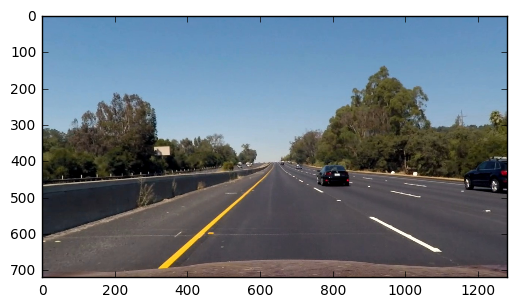

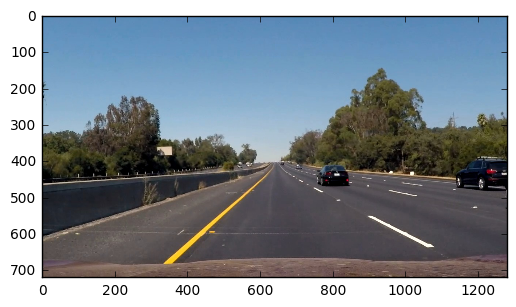

In [608]:
dist_pickle = pickle.load( open( "../Advanced_lane_finding/camera_cal/wide_dist_pickle.p", "rb" ) )

image_test = sc.misc.imread('extracted_images/frame1257.jpg')

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
undistorted_image = cv2.undistort(image_test, mtx, dist, None, mtx)
plt.imshow(undistorted_image)
plt.show()
plt.imshow(image_test)
plt.show()

In [618]:
def pipeline_full(image):
    window_img, windows_pred, windows_proba, heatmap, contours, contours_proba = pipeline(image = image) 

    #### plot the window_img:
    plt.imshow(window_img)
    plt.title('window_img')
    plt.show()
    #### plot the heatmap:
    plt.imshow(heatmap,cmap='gray')
    plt.title('heatmap')
    plt.show()

    ### for plotting:
    image_copy = image.copy()
    _colors_ = [(255,0,0), (0,255,0), (0,0,255), (0,255,255), (255,255,255), (100,100,100)]
        
    # 1. Update status of detected cars
    for car in AllCars.cars:
        if car.detected == False and car.detected_count <= 7:
            print('DELETING CAR1')
            AllCars.cars.remove(car)
        
        if car.detected == True and car.detected_from_match >= 12:
            print('DELETING CAR FROM MATCH')
            AllCars.cars.remove(car)
        
        car.detected = False
        car.undetected_count = car.undetected_count + 1
        if car.undetected_count > 5:
            print('DELETING CAR')
            AllCars.cars.remove(car)
                
    # 2. Iterate over the contours that were found
    detected_contours = []
    for contour_i, contour in enumerate(contours):
        contour_proba = contours_proba[contour_i]
        if contour_i not in detected_contours:
            detected = False
            x,y,w,h = cv2.boundingRect(contour)

            # contour is too small
            if w < 50 or h < 50:
                break

            # get the centroid of the contour
            M = cv2.moments(contour)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])

            # 1. does the contour contain an existing car (look at centroid of car)
            match_location = []
            for car_i, car in enumerate(AllCars.cars):
                if (car.detected_count > 0 and car.cx > x and car.cx < x + w and car.cy > y  and car.cy < y + h):
                    print('Car', car_i, 'is there!')
                    match_location.append([car.y, car.x])

            ############################ CONTOUR CONTAINS MORE THAN 1 CAR ############################
            # Get the cars and match their image to get their location
            if len(match_location) > 1:
                match_location = []
                current_cars = []
                for car_i, car in enumerate(AllCars.cars): 
                    if (car.detected_count > 0 and car.cx > x and car.cx < x + w  and car.cy > y and car.cy < y + h):

                        res = cv2.matchTemplate(image, car.images[0], cv2.TM_CCOEFF)
                        if res is not None:
                            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                            print('match!:', min_val, max_val, min_loc, max_loc)
                            print('car location center:', car.cx, car.cy, 'rect:', car.x, car.y, car.w, car.h)

                            if (np.sqrt((car.x - max_loc[0])**2 + (car.y - max_loc[1])**2) < 50):
                                match_location.append([max_loc[0], max_loc[1]])
                                print('Car', car_i, 'is indeed there!')
                                current_cars.append(car)

            print('Number of cars in the contour:', len(match_location))

            ############################ CONTOUR CONTAINS MORE THAN 1 CAR ############################
            if (len(match_location) > 1):
                detected = True
                mincarx = match_location[0][0]
                maxcarx = match_location[0][0] + current_cars[0].w
                # Calculate the overlap of the cars contained in the contour
                is_overlap = False
                for car_idx, car in enumerate(current_cars):
                    if car_idx > 0:
                        mincarx2 = match_location[car_idx][0]
                        maxcarx2 = match_location[car_idx][0] + car.w
                        overlap = min(maxcarx, maxcarx2) - max(mincarx, mincarx2)
                        if overlap > 40:
                            is_overlap = True
                            break
                # If there is too much overlap, delete the cars and create one from the contour
                if (is_overlap == True):
                    for car_idx, car in enumerate(current_cars):
                        AllCars.cars.remove(car)
                    print('creating a new car from the 2 existing cars')
                    newcar = Car(cx,cy,x,y,w,h)
                    newcar.images.append(image[y:y+h, x:x+w, :])
                    newcar.detected = True
                    newcar.detected_count = 10
                    newcar.detected_from_match = 0
                    AllCars.cars.append(newcar)
                # If the overlap is not too much, keep the cars separate
                else:
                    for car_idx, car in enumerate(current_cars):   
                        car.detected = True
                        car.undetected_count = 0
                        max_loc_0 = match_location[car_idx][0]
                        max_loc_1 = match_location[car_idx][1]
                        car.update_rect(x = int(max_loc_0), y = int(max_loc_1))
                        car.update_centroids(int(max_loc_0 + car.w/2), int(max_loc_1 + car.h/2))
                        car.detected_count = car.detected_count + 1
                        car.detected_from_match = 0

            ############################ CONTOUR CONTAINS 1 CAR OR LESS ############################
            if (len(match_location) <= 1):
                for car_i, car in enumerate(AllCars.cars):
                    print('Car', car_i)
                    # Look for an existing car inside the contour
                    if (car.cx > x and car.cx < x + w  and car.cy > y and car.cy < y + h):
                        print('Car', car_i, 'is contained in the contour')
                        car.detected = True
                        car.undetected_count = 0
                        car.detected_count = car.detected_count + 1
                        if (contour_proba > 4):
                            car.detected_count_needed = 3

                        if car.w > 0:
                            print('ratio', w/car.w, 'w:', w)
                            
                        # If the contour is big enough, update the car information
                        if (w >= car.w*2/3 or w > 200):
                            print('before update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                            print('before:', car.cxs, car.cx)
                            car.update_centroids(int(cx),int(cy))
                            print('after update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                            print('after:', car.cxs, car.cx)
                            car.update_rect(int(x),int(y),int(w),int(h))
                            insert_array(car.images, image[y:y+h, x:x+w, :], 4)
                        # Otherwise, contour is too small (part of the image are probably undetected)
                        else:
                            print('contour seems too small, not updating')

                        car.detected_from_match = 0

                        detected = True
                        print('breakinf')
                        break

                    # If no existing car inside the contour, look for an existing car close to it
                    else:
                        if (car.cx > x - 50 and car.cx < x + w + 50  and car.cy > y - 50 and car.cy < y + h + 50):
                            close_other_contour = False
                            for other_contour_i, other_contour in enumerate(contours):
                                if other_contour_i != contour_i:
                                    x2,y2,w2,h2= cv2.boundingRect(other_contour)
                                    if (car.cx > x2 - 50 and car.cx < x2 + w2 + 50 and car.cy > y2 - 50 and car.cy < y2 + h2 + 50):
                                        close_other_contour = True
                                        
                                        # Car is close to another contour too!
                                        combined_w = w + w2
                                        print('CAR IS CLOSE TO ANOTHER CONTOUR', 'ratio combined_w/car.w', combined_w/car.w, 'combined_w:', combined_w)

                                        M2 = cv2.moments(other_contour)
                                        cx2 = int(M['m10']/M['m00'])
                                        cy2 = int(M['m01']/M['m00'])
                                        
                                        # If the combined contours are about the size of the car and is not too wide, assign the car to combination
                                        if combined_w/car.w < 1.5 and combined_w < 250:
                                            detected = True
                                            detected_contours.append(contour_i)
                                            detected_contours.append(other_contour_i)
                                            print('COMBINED ARRAYS ARE SMALLER THAN 1.5 THE CAR WIDTH')
                                            # If the car had already been assigned to the other contour, remove assignment
                                            if car.detected == True:
                                                print('CAR WAS ALREADY DETECTED => REASSIGNING')
                                                car.cxs.pop()
                                                car.cys.pop()
                                                car.xs.pop()
                                                car.ys.pop()
                                                car.hs.pop()
                                                car.ws.pop()
                                                car.images.pop()
                                            # (Re)assign car to the combination
                                            print('before update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                                            print('before:', car.cxs, car.cx)
                                            car.update_centroids(int((cx+cx2)/2),int((cy+cy2)/2))
                                            print('after update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                                            print('after:', car.cxs, car.cx)
                                            car.update_rect(min(x,x2),min(y,y2),int(w+w2),int(h+h2))
                                            insert_array(car.images, image[min(y,y2):min(y,y2)+int(h+h2), min(x,x2):min(x,x2)+int(w+w2), :], 4)
                                            
                                            print('Car is close to:', x2,y2,w2,h2, 'current contour:', x,y,w,h)
                                        
                                        # If the combined contours too big, delete cars and create 2 new ones
                                        elif combined_w/car.w < 1.5 and combined_w >= 250:
                                            
                                            print('DELETING CAR TO CREATE 2 NEW ONES')
                                            AllCars.cars.remove(car)
                                            
                                            print('creating a new car 1')
                                            newcar = Car(cx,cy,x,y,w,h)
                                            newcar.images.append(image[y:y+h, x:x+w, :])
                                            newcar.detected = True
                                            newcar.detected_count = 10
                                            newcar.detected_from_match = 0
                                            AllCars.cars.append(newcar)
                                            
                                            print('creating a new car 2')
                                            newcar = Car(cx2,cy2,x2,y2,w2,h2)
                                            newcar.images.append(image[y2:y2+h2, x2:x2+w2, :])
                                            newcar.detected = True
                                            newcar.detected_count = 10
                                            newcar.detected_from_match = 0
                                            AllCars.cars.append(newcar)
                                        

                            # If car is close to no other contour:
                            if close_other_contour == False:
                                print('Car is close to no other contour')
                                contour_diff = np.sqrt((w - car.w)**2 + (h - car.h)**2)

                                print('contour is ok')
                                car.detected = True
                                car.undetected_count = 0
                                car.detected_count = car.detected_count + 1

                                if car.w > 0:
                                    print('ratio', w/car.w, 'w:', w)
                                if (w >= car.w*2/3 or w > 200):
                                    print('before update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                                    print('before:', car.cxs, car.cx)
                                    car.update_centroids(int(cx),int(cy))
                                    print('after update len(car.cxs), len(car.cys)', len(car.cxs), len(car.cys))
                                    print('after:', car.cxs, car.cx)
                                    car.update_rect(int(x),int(y),int(w),int(h))
                                    insert_array(car.images, image[y:y+h, x:x+w, :], 4)
                                else:
                                    print('contour seems too small, not updating')

                                car.detected_from_match = 0

                                detected = True
                                print('breakinf')
                                break



            if (not detected):  
                print('creating a new car')
                newcar = Car(cx,cy,x,y,w,h)
                newcar.images.append(image[y:y+h, x:x+w, :])
                newcar.detected = True
                newcar.detected_count = 1
                newcar.detected_from_match = 0
                if contour_proba > 4:
                    newcar.detected_count_needed = 3
                else:
                    newcar.detected_count_needed = 10
                AllCars.cars.append(newcar)

            # TODO: Go through the existing cars and delete the ones that are very close

        
    # Go through the existing cars that were not detected...
    detected_cars = [car for car in AllCars.cars if car.detected == True]
    undetected_cars = [car for car in AllCars.cars if car.detected == False]
    
    for car in undetected_cars:
        print('LOOKING FOR UNDETECTED CARS')
        if car.detected_count >= car.detected_count_needed:
            # check if it is inside the new square
            carinbiggerbox = False
            for dcar in detected_cars:
                if(car.cx > dcar.x and car.cx < dcar.x + dcar.w and car.cy > dcar.y and car.cy < dcar.y + dcar.h):
                    print('car is now in a bigger box')
                    dcar.detected_count = 10
                    dcar.detected_from_match = 0
                    AllCars.cars.remove(car)
                    carinbiggerbox = True
                    break
#                dist = np.sqrt((car.cx - dcar.cx)**2 + (car.cy - dcar.cy)**2)
#                 print(dist)
#                 if (dist < 50):
#                     print('car is closer!')
#                     dcar.detected_count = 10
#                     AllCars.cars.remove(car)
#                     carinbiggerbox = True
#                     break
            if (carinbiggerbox == False):
                # look for the car
                print('looking')
                if car.x > 50:
                    area_to_look_for = image[max(0,car.y-50):car.y+car.h+50+max(car.images[0].shape[0]-(car.h+100),0), max(car.x-50,0):car.x+car.w+50+max(car.images[0].shape[1]-(car.w+100),0), :]
                    print('car.y-50:car.y+car.h+50, car.x-50:car.x+car.w+50:', max(0,car.y-50),car.y+car.h+50, max(car.x-50,0),car.x+car.w+50)
                    print('car.y-50:car.y+car.h+50+max(car.images[0].shape[0]-(car.h+100),0):', max(0,car.y-50),car.y+car.h+50+max(car.images[0].shape[0]-(car.h+100),0), max(car.x-50,0),car.x+car.w+50+max(car.images[0].shape[1]-(car.w+100),0))
                    print(car.images[0].shape)
    #                 plt.imshow(area_to_look_for)
    #                 plt.title('area to look for')
    #                 plt.show()

    #                 plt.imshow(car.images[0])
    #                 plt.title('car image')
    #                 plt.show()


                    res = cv2.matchTemplate(area_to_look_for, car.images[0], cv2.TM_CCOEFF)
                    if res is not None:
                        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                        print('match!:', min_val, max_val, min_loc, max_loc)
                        print('car location center:', car.cx, car.cy, 'rect:', car.x, car.y, car.w, car.h)

                        car.detected_count = car.detected_count + 1
                        car.undetected_count = 0
                        car.update_rect(car.x-50 + max_loc[0], car.y-50 + max_loc[1])
                        car.update_centroids(int(car.x-50 + max_loc[0] + car.w/2), int(car.y-50 + max_loc[1] + car.h/2))
                        car.detected = True
                        car.detected_from_match = car.detected_from_match + 1


    # plot from objects:
    for i, car in enumerate(AllCars.cars):
        if car.detected == True and car.detected_count >= car.detected_count_needed:        
            cv2.rectangle(image_copy,(car.x, car.y),(car.x + car.w, car.y + car.h),_colors_[i%6],2)
            cv2.circle(image_copy, (car.cx, car.cy), radius = 5, color = _colors_[i%6], thickness = 10) 
    
#     plt.imshow(image_copy)
#     plt.show()
    
    return image_copy


(98, 322)
max heatmap contour: 10.3989 1.67827


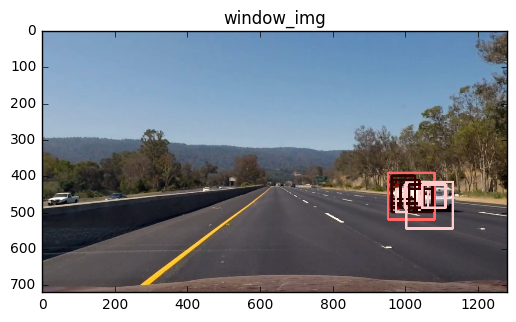

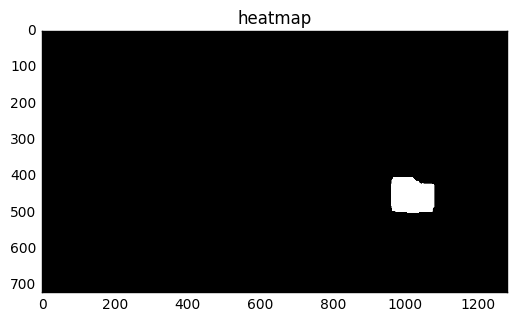

Number of cars in the contour: 0
creating a new car


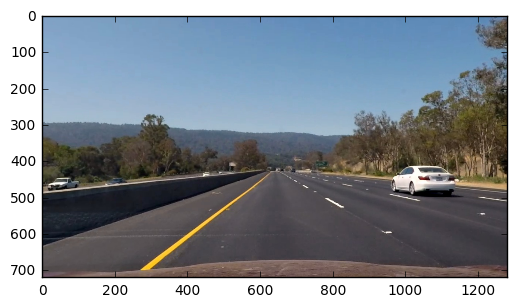

In [613]:
image = sc.misc.imread('extracted_images/frame64.jpg') #bbox-example-image.jpg 751 1051 1001 extractfromvideoNew
recent_windows_pred = [] 
recent_windows_proba = [] 
AllCars = Cars()
r = pipeline_full(image)
plt.imshow(r)
plt.show()

0 extracted_images/begframes/frame0.jpg
####################################


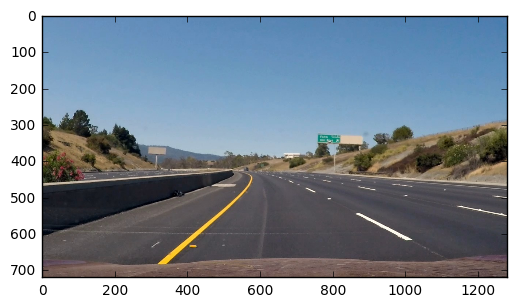

1 extracted_images/begframes/frame01.jpg
####################################


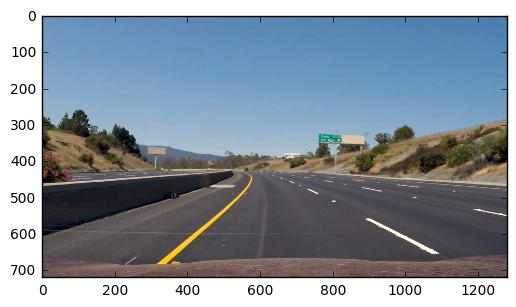

2 extracted_images/begframes/frame02.jpg
####################################


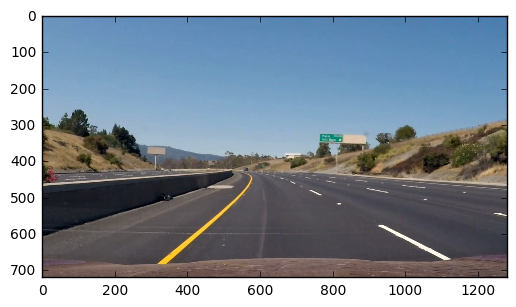

3 extracted_images/begframes/frame03.jpg
####################################


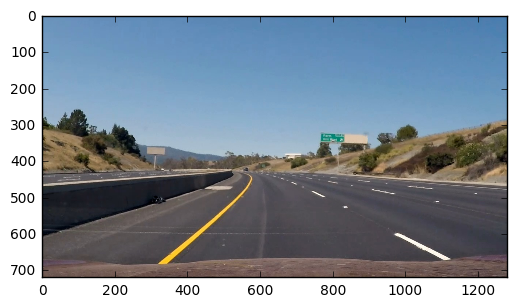

4 extracted_images/begframes/frame04.jpg
####################################


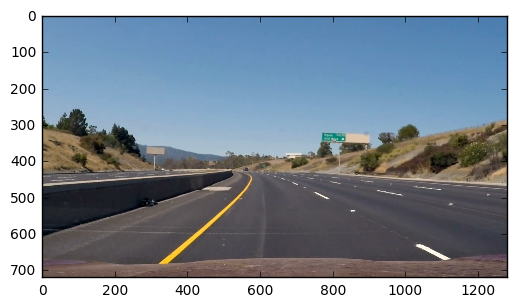

5 extracted_images/begframes/frame05.jpg
####################################


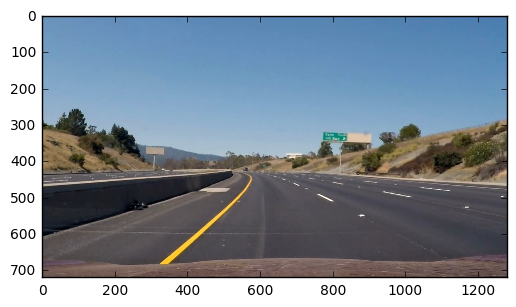

6 extracted_images/begframes/frame06.jpg
####################################


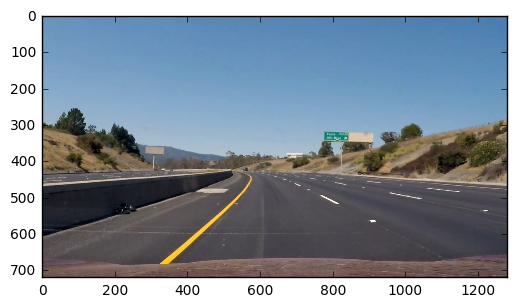

7 extracted_images/begframes/frame07.jpg
####################################
Number of cars in the contour: 0
creating a new car


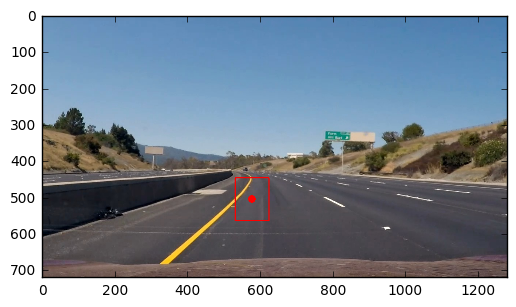

8 extracted_images/begframes/frame08.jpg
####################################


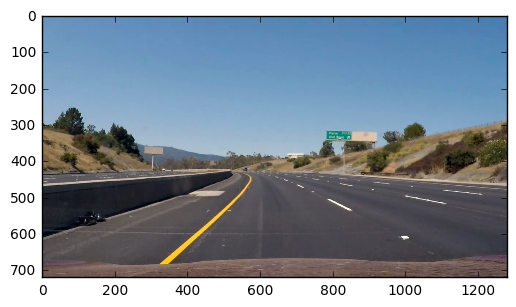

9 extracted_images/begframes/frame09.jpg
####################################


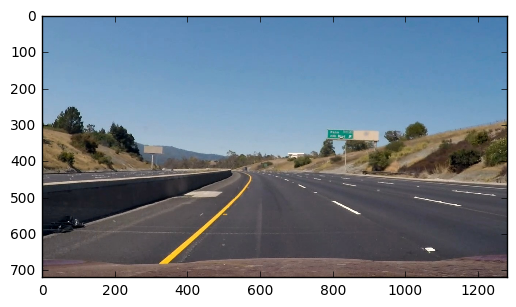

10 extracted_images/begframes/frame10.jpg
####################################


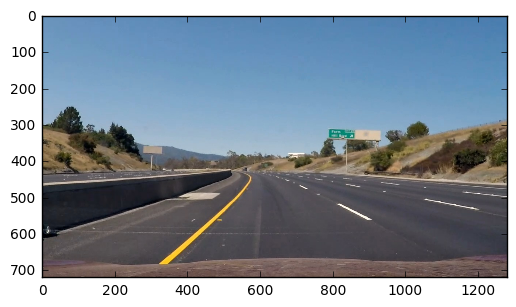

11 extracted_images/begframes/frame11.jpg
####################################


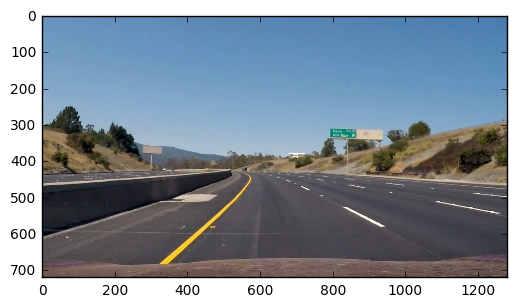

12 extracted_images/begframes/frame12.jpg
####################################


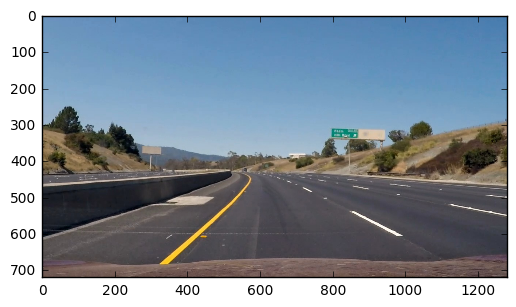

13 extracted_images/begframes/frame13.jpg
####################################


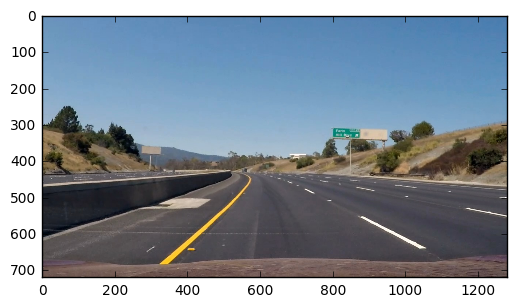

14 extracted_images/begframes/frame14.jpg
####################################


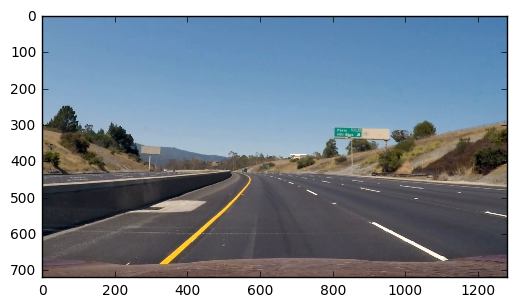

15 extracted_images/begframes/frame15.jpg
####################################


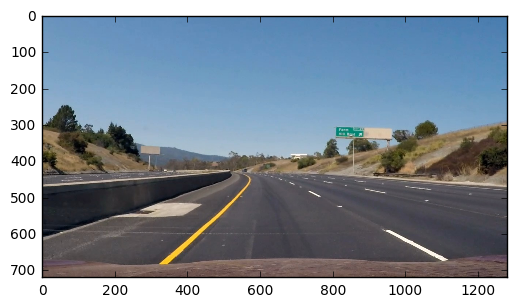

16 extracted_images/begframes/frame16.jpg
####################################


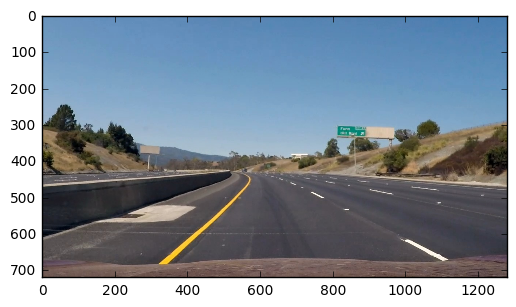

17 extracted_images/begframes/frame17.jpg
####################################


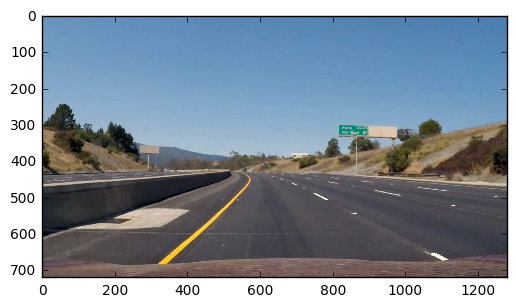

18 extracted_images/begframes/frame18.jpg
####################################


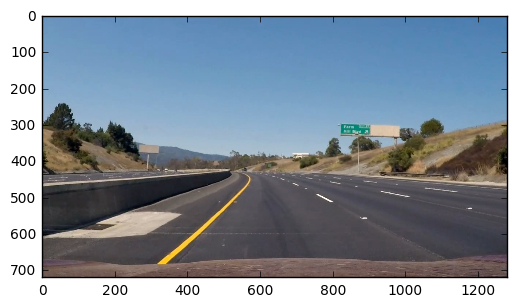

19 extracted_images/begframes/frame19.jpg
####################################


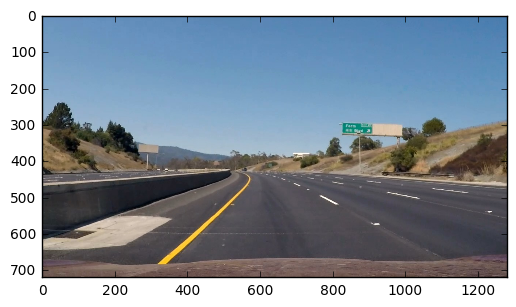

20 extracted_images/begframes/frame20.jpg
####################################


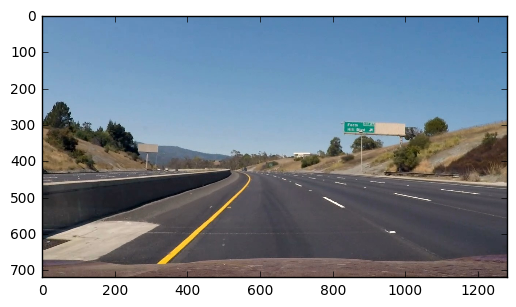

21 extracted_images/begframes/frame21.jpg
####################################


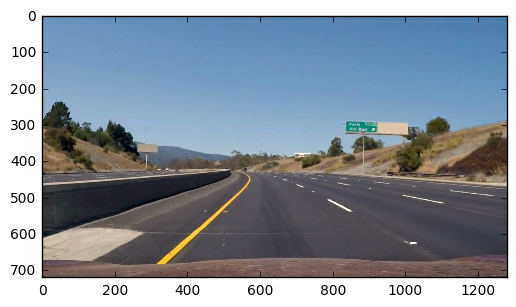

22 extracted_images/begframes/frame22.jpg
####################################


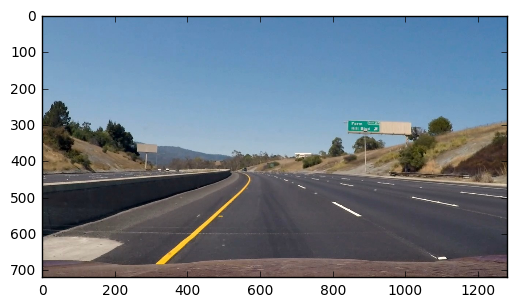

23 extracted_images/begframes/frame23.jpg
####################################


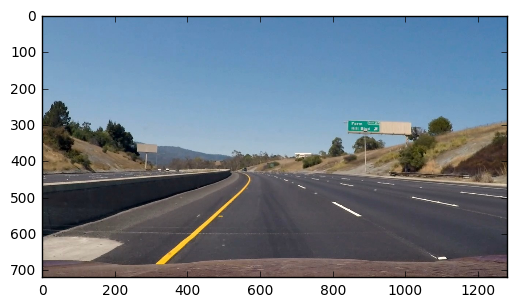

In [357]:
images = glob.glob('extracted_images/begframes/*.jpg')

for i, file in enumerate(images):
    print(i, file)
    print('####################################')
    image = sc.misc.imread(file)
    recent_windows_pred = [] 
    recent_windows_proba = [] 
    AllCars = Cars()
    r = pipeline_full(image)
    plt.imshow(r)
    plt.show()

### TODO: Try detect contour on the heatmap directly instead of that combination

# Video pipeline

### Heatmap over an average of 7 frames

### Reject inconsistent blobs?

### VIDEO

In [619]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

recent_windows_pred = [] 
recent_windows_proba = [] 
AllCars = Cars()

white_output = 'project-video-output-distorted.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(8,18)
white_clip = clip1.fl_image(pipeline_full)

%time white_clip.write_videofile(white_output, audio=False)

OSError: MoviePy error: the file project_video.m4 could not be found !
Please check that you entered the correct path.

In [ ]:
# TODO: look for the known cars in the contours. If they is extra room, use it.
# Retry the blob only approach (to see if it gets them most of the time)

1
27


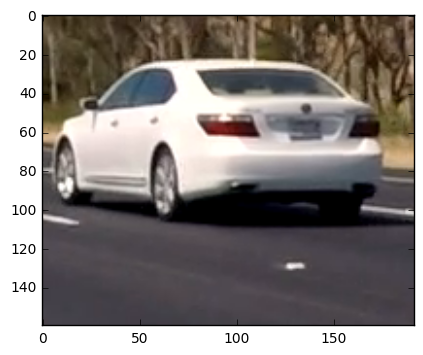

In [1006]:
print(len(AllCars.cars))
print(len(AllCars.cars[0].images))
plt.imshow(AllCars.cars[0].images[5])
plt.show()

In [603]:
# Extract frame from video if necessary
# Import the necessary packages
# import argparse
# import cv2

vidcap = cv2.VideoCapture("project_video.mp4")
success,image = vidcap.read()
count = 0;
while count <= 1270:
    success,image = vidcap.read()
    if count in (1255, 1256, 1257, 1258):
        cv2.imwrite("extracted_images/frame%d.jpg" % count, image)     # save frame as JPEG file
    count += 1

In [481]:
# let's try the same with 5 images from myself

In [60]:
car_list_test = ['non-vehicles/Extras/extra42.png',
                'non-vehicles/Extras/extra17.png',
                'non-vehicles/Extras/extra57.png',
                'vehicles/KITTI_extracted/18.png',
                'vehicles/KITTI_extracted/257.png']
car_features = extract_features(car_list_test, cspace=_CSPACE_, cspacehog=_CSPACE_HOG_, spatial_size=_SPATIAL_SIZE_,
                        hist_bins=_HIST_BINS_, hist_range=_HIST_RANGE_, orient=_ORIENT_, pix_per_cell=_PIX_PER_CELL_, 
                        cell_per_block=_CELL_PER_BLOCK_, hog_channel=_HOG_CHANNEL_)

X_feature_testimages = np.asarray(car_features).astype(np.float64) 
# Apply the scaler to X
print('X_feature_testimages.shape:', X_feature_testimages.shape)
scaled_X_feature_testimages = X_scaler.transform(X_feature_testimages)

predictions_testimages = clf.predict(scaled_X_feature_testimages)
predictions_testimages

X_feature_testimages.shape: (5, 1764)


array([ 0.,  0.,  0.,  1.,  1.])